In [109]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime

In [110]:
# --- Global style (Helvetica + clean defaults) ---
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"],
    # Make mathtext look like Helvetica too (for the $n_{...}$ labels)
    "mathtext.fontset": "custom",
    "mathtext.rm": "Helvetica",
    "mathtext.it": "Helvetica:italic",
    "mathtext.bf": "Helvetica:bold",

    "figure.dpi": 200,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": False,
    'axes.linewidth': 1.5,  # thickness of the axis spines

    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,

    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'xtick.minor.width': 1.0,
    'ytick.minor.width': 1.0,
})

In [111]:

# Paths to the uploaded CSV files
file_paths = [[f'data/Methane/M{j}_{i}.csv' for i in range(3)] for j in range(1,6)]

# Read all CSVs and store in a list
arrays = []
for paths in file_paths:
    array = []
    for path in paths:
        df = pd.read_csv(path)  # Set header=None if there's no header row
        array.append(df.values)
    array = np.vstack(array)
    arrays.append(array)

# Paths to the uploaded CSV files
file_paths = [[f'data/Ethylene/E{j}_{i}.csv' for i in range(3)] for j in range(1,6)]

# Read all CSVs and store in a list
for paths in file_paths:
    array = []
    for path in paths:
        df = pd.read_csv(path)  # Set header=None if there's no header row
        array.append(df.values)
    array = np.vstack(array)
    arrays.append(array)

# Paths to the uploaded CSV files
file_paths = [[f'data/CO/C{j}_{i}.csv' for i in range(3)] for j in range(1,6)]

# Read all CSVs and store in a list
for paths in file_paths:
    array = []
    for path in paths:
        df = pd.read_csv(path)  # Set header=None if there's no header row
        array.append(df.values)
    array = np.vstack(array)
    arrays.append(array)

In [112]:
len(arrays)

15

In [113]:
sensor_id = ["U1-TGS2602", "U2-TGS2610-D00", "U3-SP3S-AQ2", "U4-GSBT11-DXX",
             "U8-TGS2600", "U9-TGS2603", "U10-TGS2630", "U13-TGS2612-D00",
             "U14-TGS2620", "U15-MG-812", "U16-TGS-3830", "U19-TGS1820",
             "U20-TGS2611-E00", "U21-TGS2616-C00", "U22-WSP2110", "U25-TGS-3870",
             "U7-BME680"]

sensor_pos = [[0,1], [0,3], [2,2], [2,3],
              [0,0], [0,2], [2,0], [1,1],
              [1,3], [3,1], [3,3], [3,2],
              [1,0], [1,2], [3,0], [2,1]]

sensor_addr = [[0x49, 1],[0x49, 3],[0x4b, 2],[0x4b, 3],
               [0x49, 0],[0x49, 2],[0x4b, 0],[0x48, 1],
               [0x48, 3],[0x4a, 1],[0x4a, 3],[0x4a, 2],
               [0x48, 0],[0x48, 2],[0x4a, 0],[0x4b, 1],
               [0x76, 99]]

sensor_addr_to_tag = [[0x49, 0], [0x4b, 1], [0x48, 2], [0x4a, 3],]

adc_addr = [0x48, 0x49, 0x4a, 0x4b]

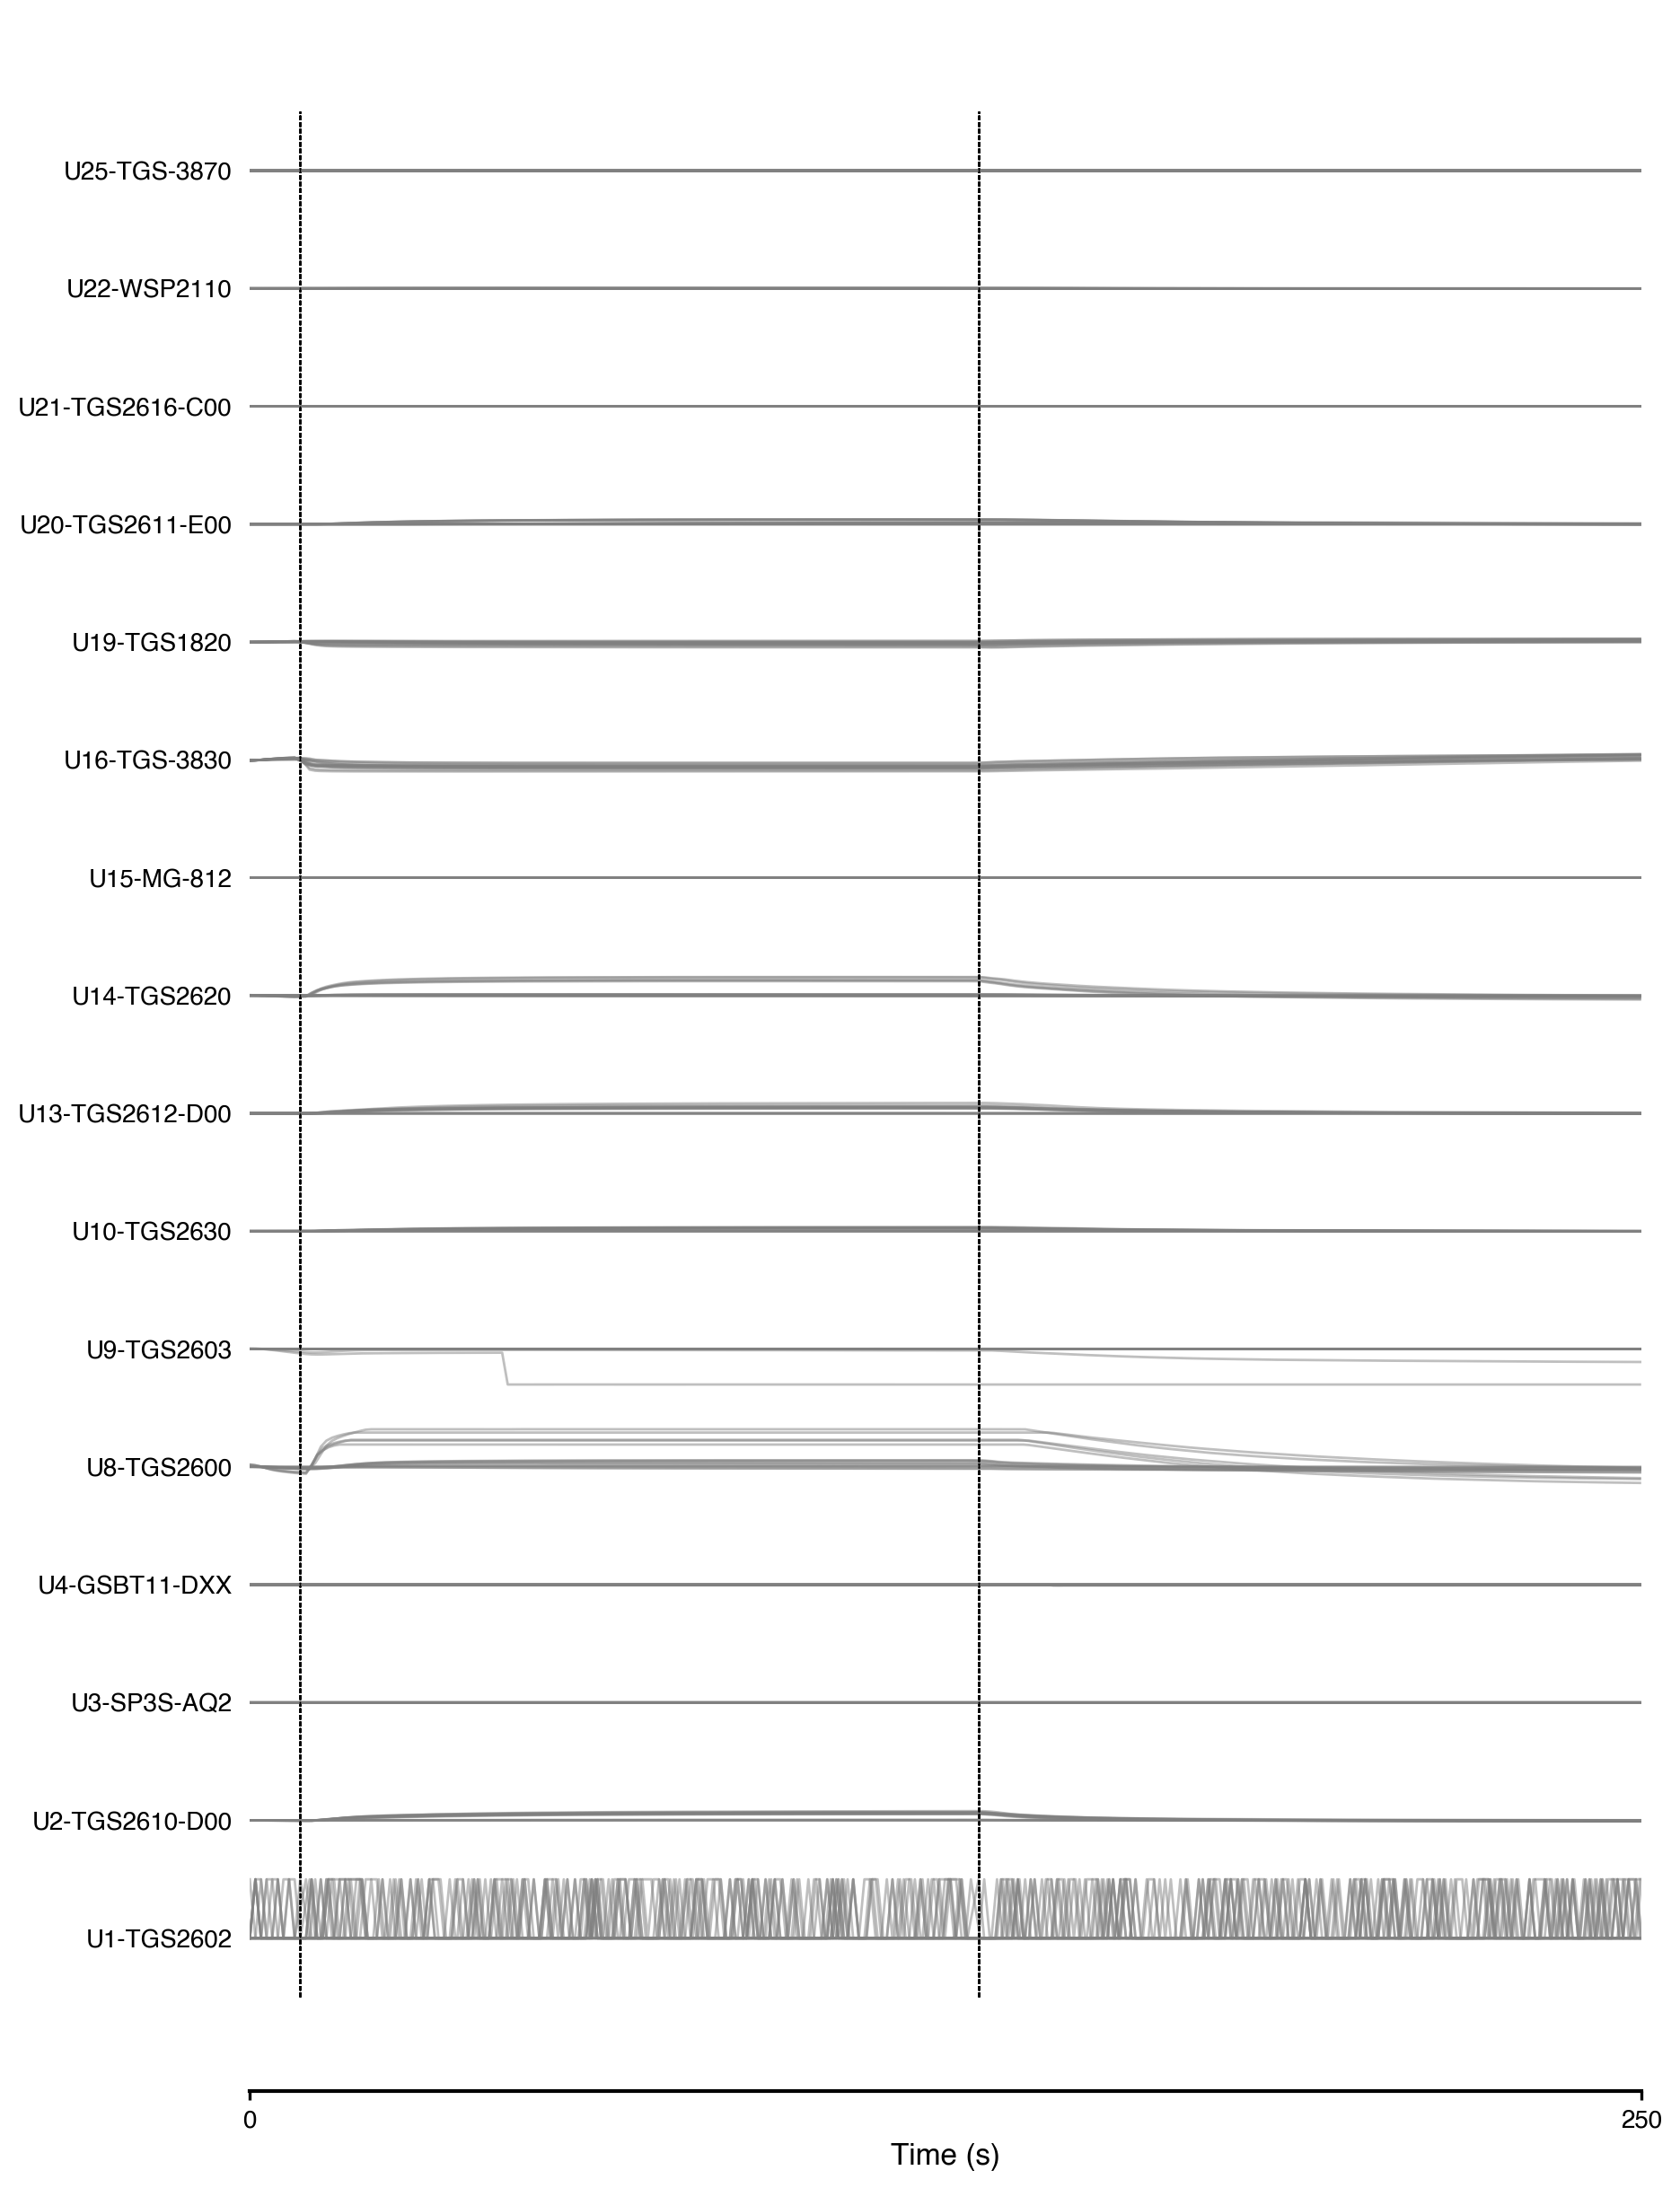

In [114]:
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111)

fmt = '%Y-%m-%d %H:%M:%S.%f'

stack_data = []
stack_times = []

for array in arrays:
    time0 = datetime.strptime(array[0, 0], fmt)
    times = [(datetime.strptime(row[0], fmt) - time0).total_seconds() for row in array]
    sensor_data = []

    for i in range(16):
        values = []
        for read in array:
            values.append(int.from_bytes(read[2*i+2:2*i+4].tolist(), byteorder="little"))    # Check with Herman
        sensor_data.append(values)
    stack_data.append(np.vstack(sensor_data))
    stack_times.append(times)

    for i, row in enumerate(sensor_data):
        if i==0:
            baseline = 0.
            signal = (np.array(row) - baseline)/65536.
            ax.plot(times, signal, label=sensor_id[i], color='gray', linewidth=1, alpha=0.5)
        else:
            baseline = np.mean(row[:5])
            signal = (np.array(row) - baseline)/65536.
            ax.plot(times, signal*2 + 2*i , label=sensor_id[i+1], color='gray', linewidth=1, alpha=0.5)
    ax.set_yticks(2*np.arange(16), labels=sensor_id[:-1])
    ax.set_xticks([times[0], times[-1]], labels=[0,250])
    ax.set_xlabel('Time (s)')
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.tick_params(left=False, labelleft=True)
    ax.set_xlim([times[0], times[-1]])
    ax.vlines(9, -1, 31, colors='black', linestyles='dashed', linewidth=0.5)
    ax.vlines(130, -1, 31, colors='black', linestyles='dashed', linewidth=0.5)
plt.savefig('figs/methane.pdf', bbox_inches='tight')
plt.savefig('figs/methane.png', dpi=200, bbox_inches='tight')

a = 3761.44, b = 13.5736


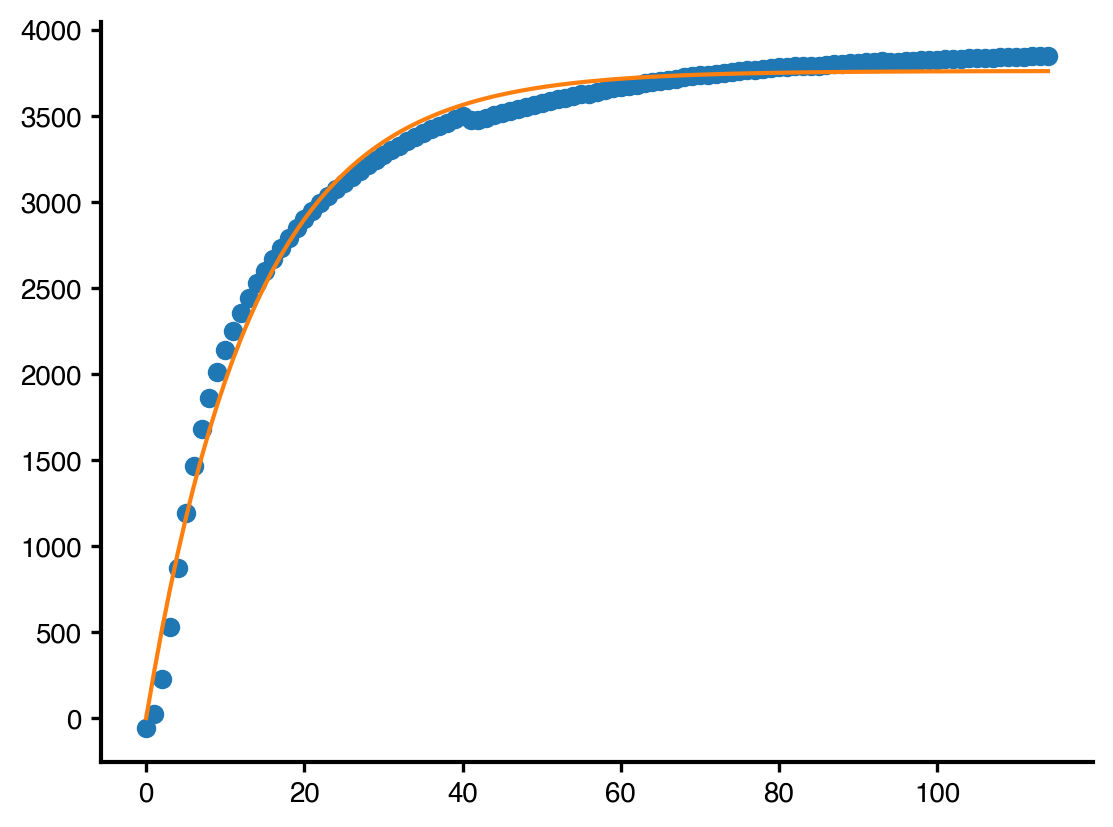

In [130]:
import numpy as np
from scipy.optimize import curve_fit

# --- model ---
def sat_exp(x, a, b):
    return a * (1 - np.exp(-x / b))

# --- get your data slices ---
data = stack_data[0]
times = stack_times[0]

y = np.asarray(data)[1, 10:125] - np.mean(data[1, :10], axis=0)
x = np.asarray(times)[10:125] - times[10]

# # --- clean NaNs / infs ---
# m = np.isfinite(x) & np.isfinite(y)
# x, y = x[m], y[m]

# --- sensible initial guesses ---
a0 = float(np.max(y)) if y.size else 1.0

# estimate b0: x where y ≈ 0.6321 * a (time-constant heuristic)
target = 0.6321205588 * a0
if np.any(y >= target):
    b0 = float(x[np.argmax(y >= target)])
    b0 = b0 if b0 > 0 else 1.0
else:
    # fallback from initial slope
    if x.size >= 2:
        m0 = np.max(np.gradient(y, x))  # avoid zero by taking max slope
        b0 = float(a0 / m0) if m0 > 0 else max(1.0, (np.ptp(x) / 5.0))
    else:
        b0 = 1.0

# --- fit with positivity constraints on a and b ---
popt, pcov = curve_fit(sat_exp, x, y, p0=[a0, b0], bounds=(0, np.inf))
a_hat, b_hat = popt

print(f"a = {a_hat:.6g}, b = {b_hat:.6g}")

# Optional: fitted curve on the same x points
y_fit = sat_exp(x, *popt)
plt.plot(x, y, 'o', label='Data')
plt.plot(x, y_fit, '-', label='Fitted curve')
plt.show()

In [147]:
import numpy as np
from scipy.optimize import curve_fit

# models
def sat_exp(x, a, b):      # rises to +a
    return a * (1 - np.exp(-x / b))

def sat_exp_inv(x, a, b):  # falls to -a  (same as -a*(1-exp(-x/b)))
    return a * (np.exp(-x / b) - 1)

def fit(x, Y, mode="rise"):
    """
    mode: "rise" -> fit sat_exp (y -> +a)
          "fall" -> fit sat_exp_inv (y -> -a)
    """
    eps = 1e-12
    fits = []
    y_fits = []

    for i, y in enumerate(Y):
        m = np.isfinite(x) & np.isfinite(y)
        xi, yi = x[m], y[m]
        if xi.size < 3:
            fits.append((np.nan, np.nan))
            y_fits.append(np.full_like(y, np.nan))
            continue

        # --- initial guesses (kept inside bounds) ---
        if mode == "rise":
            a0 = max(np.max(yi), eps)  # positive magnitude
            target = 0.6321205588 * a0
            if np.any(yi >= target):
                b0 = float(xi[np.argmax(yi >= target)])
                b0 = max(b0, eps)
            else:
                m0 = np.max(np.gradient(yi, xi))
                b0 = max((a0 / m0) if m0 > eps else (np.ptp(xi) / 5.0), eps)
            f = sat_exp

        elif mode == "fall":
            # negative curve: use magnitude from the most negative value
            a0 = max(-np.min(yi), eps)  # magnitude >= 0
            target = -0.6321205588 * a0
            if np.any(yi <= target):
                b0 = float(xi[np.argmax(yi <= target)])
                b0 = max(b0, eps)
            else:
                m0 = np.max(np.gradient(-yi, xi))  # slope magnitude
                b0 = max((a0 / m0) if m0 > eps else (np.ptp(xi) / 5.0), eps)
            f = sat_exp_inv

        # --- fit (bounds strictly positive) ---
        try:
            popt, _ = curve_fit(f, xi, yi, p0=[a0, b0],
                                bounds=([eps, eps], [np.inf, np.inf]))
            fits.append(tuple(popt))
            # predict on the original x for this row (keep shape)
            yhat = np.full_like(y, np.nan, dtype=float)
            yhat[m] = f(xi, *popt)
            y_fits.append(yhat)
        except (RuntimeError, ValueError):
            fits.append((np.nan, np.nan))
            y_fits.append(np.full_like(y, np.nan))

    return np.array(fits), np.array(y_fits)

In [149]:
stack_response = []
responses = []
tau_exposure = []
tau_recovery = []

for i in range(3):
    for j, data in enumerate(stack_data[5*i:5*(i+1)]):
        times = stack_times[5*i + j]

        baseline = np.mean(data[:, :10], axis=1)
        onset_steady = np.mean(data[:, 110:125], axis=1)
        response = np.abs(onset_steady - baseline)
        stack_response.append(response)

        # Exposure fit (rising)
        x = np.asarray(times)[10:125] - np.asarray(times)[10]
        Y = np.asarray(data)[:, 10:125] - baseline[:, None]
        fits_exposure, y_fits_exposure = fit(x, Y, mode="rise")

        # Recovery fit (falling)
        x = np.asarray(times)[140:245] - np.asarray(times)[140]
        Y = np.asarray(data)[:, 140:245] - np.asarray(data)[:, 140][:, None]
        fits_recovery, y_fits_recovery = fit(x, Y, mode="fall")

    avg_response = np.mean(np.vstack(stack_response), axis=0)
    avg_response = (avg_response - np.min(avg_response)) / (np.max(avg_response) - np.min(avg_response))
    responses.append(avg_response)
    tau_exposure.append(fits_exposure[:,1])
    tau_recovery.append(fits_recovery[:,1])



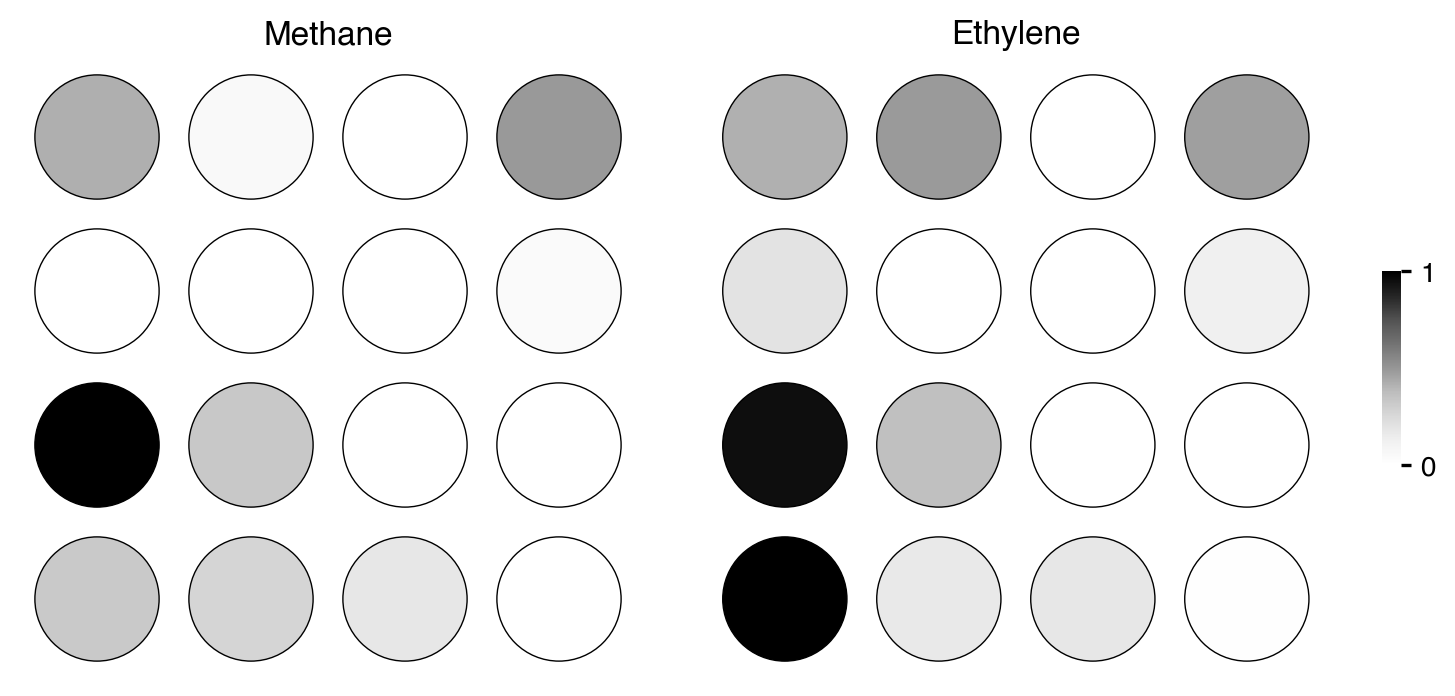

In [120]:
fig = plt.figure(figsize=(9, 4))
gs = fig.add_gridspec(1,3, width_ratios=[1,1,0.03],
                      wspace=0.1, hspace=0.1
                      )
cmap = 'Greys'
ax0 = fig.add_subplot(gs[0,0])
ax0.set_aspect('equal')
ax1 = fig.add_subplot(gs[0,1])
ax1.set_aspect('equal')
cax = fig.add_subplot(gs[0,2])
cax.set_aspect(10)

scatter0 = ax0.scatter([pos[0] for pos in sensor_pos], [pos[1] for pos in sensor_pos],
                       s=2e3, c=responses[0], cmap=plt.get_cmap(cmap), vmin=0, vmax=1,
                       edgecolors='black', linewidth=0.5)
scatter1 = ax1.scatter([pos[0] for pos in sensor_pos], [pos[1] for pos in sensor_pos],
                       s=2e3, c=responses[1], cmap=plt.get_cmap(cmap), vmin=0, vmax=1,
                       edgecolors='black', linewidth=0.5)
plt.colorbar(scatter0, cax=cax, ticks=np.arange(0,2,1))

for ax in fig.axes[:2]:
    ax.spines[:].set_visible(False)
    ax.set_xlim([-0.5, 3.5])
    ax.set_ylim([-0.5, 3.5])
    ax.set_xticks([])
    ax.set_yticks([])
cax.spines[:].set_visible(False)

ax0.set_title('Methane', fontsize=12)
ax1.set_title('Ethylene', fontsize=12)
plt.savefig('figs/resp_avg.pdf', bbox_inches='tight')
plt.savefig('figs/resp_avg.png', dpi=200, bbox_inches='tight')

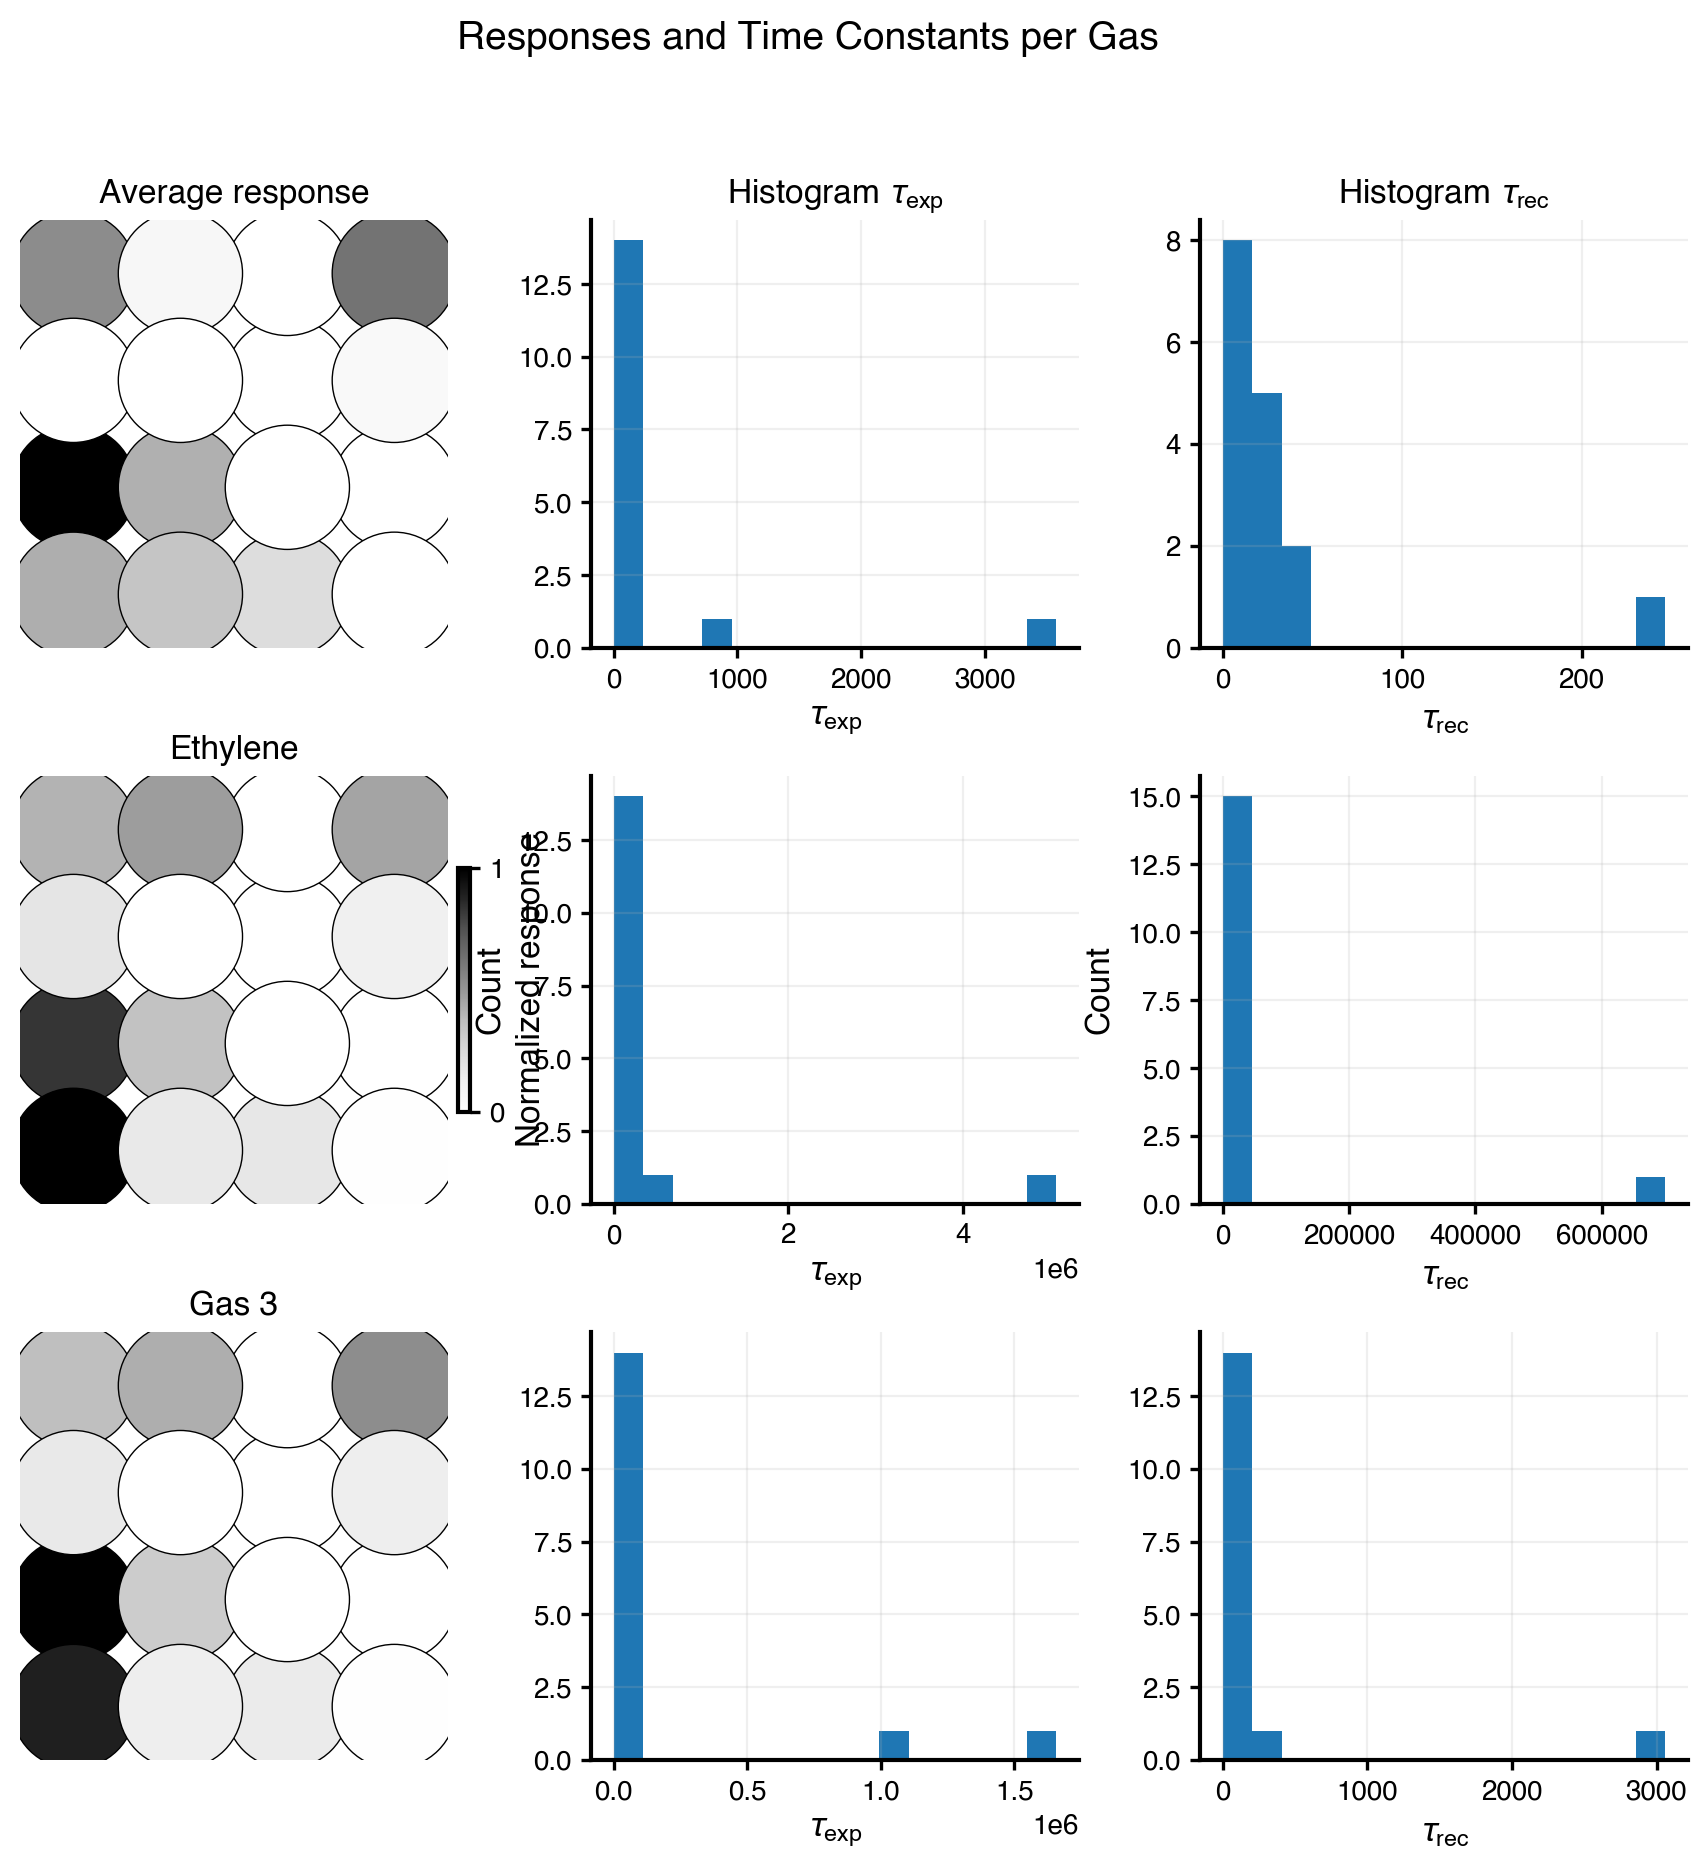

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# --- inputs assumed already computed ---
# sensor_pos: list/array of (x, y) for each sensor
# responses:  list of 3 arrays, each len == len(sensor_pos), values in [0,1] (already normalized)
# tau_exposure: list of 3 arrays (taus per sensor)
# tau_recovery: list of 3 arrays (taus per sensor)

# Optional: give names to your 3 gases (edit as needed)
gas_names = ["Methane", "Ethylene", "Gas 3"]

# --- plotting ---
fig = plt.figure(figsize=(11, 10))
gs = fig.add_gridspec(3, 3, wspace=0.25, hspace=0.3)

cmap = plt.get_cmap("Greys")
norm = Normalize(vmin=0.0, vmax=1.0)
sm = ScalarMappable(norm=norm, cmap=cmap)  # for shared colorbar

scatter_axes = []
hist_exp_axes = []
hist_rec_axes = []

xs = [pos[0] for pos in sensor_pos]
ys = [pos[1] for pos in sensor_pos]

for i in range(3):
    # --- Column 1: average response scatter ---
    ax_sc = fig.add_subplot(gs[i, 0])
    sc = ax_sc.scatter(xs, ys,
                       s=2e3, c=responses[i], cmap=cmap, norm=norm,
                       edgecolors='black', linewidth=0.5)
    ax_sc.set_aspect('equal')
    ax_sc.spines[:].set_visible(False)
    ax_sc.set_xlim([-0.5, 3.5])
    ax_sc.set_ylim([-0.5, 3.5])
    ax_sc.set_xticks([])
    ax_sc.set_yticks([])
    ax_sc.set_title(gas_names[i], fontsize=12)
    scatter_axes.append(ax_sc)

    # --- Column 2: histogram tau_exposure ---
    ax_h1 = fig.add_subplot(gs[i, 1])
    te = np.asarray(tau_exposure[i]).ravel()
    te = te[np.isfinite(te)]
    if te.size > 0:
        ax_h1.hist(te, bins=15)
    ax_h1.set_xlabel(r'$\tau_{\mathrm{exp}}$')
    ax_h1.set_ylabel('Count' if i == 1 else '')
    ax_h1.grid(True, alpha=0.2)
    hist_exp_axes.append(ax_h1)

    # --- Column 3: histogram tau_recovery ---
    ax_h2 = fig.add_subplot(gs[i, 2])
    tr = np.asarray(tau_recovery[i]).ravel()
    tr = tr[np.isfinite(tr)]
    if tr.size > 0:
        ax_h2.hist(tr, bins=15)
    ax_h2.set_xlabel(r'$\tau_{\mathrm{rec}}$')
    ax_h2.set_ylabel('Count' if i == 1 else '')
    ax_h2.grid(True, alpha=0.2)
    hist_rec_axes.append(ax_h2)

# Shared colorbar for the response scatter plots (first column)
cbar = fig.colorbar(sm, ax=scatter_axes, fraction=0.025, pad=0.02, ticks=[0, 1])
cbar.set_label("Normalized response")

# Optional tidy titles for columns
fig.suptitle("Responses and Time Constants per Gas", fontsize=14, y=0.98)
for j, title in enumerate(["Average response", r"Histogram $\tau_{\mathrm{exp}}$", r"Histogram $\tau_{\mathrm{rec}}$"]):
    fig.axes[j].set_title(title, fontsize=12)  # top row axes are first three added

# Save
plt.savefig('figs/resp_tau_grid.pdf', bbox_inches='tight')
plt.savefig('figs/resp_tau_grid.png', dpi=200, bbox_inches='tight')
plt.show()
